<a href="https://colab.research.google.com/github/ritikdes/Text_Based_Emotion_Detection/blob/main/TBED_1_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Loading & Initial Split
We first load the cleaned data and immediately split it for training pipeline.

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset we cleaned from EDA
df = pd.read_csv('/content/drive/MyDrive/goemotions_cleaned.csv')


# Extract all emotion columns (everything except 'text' is a label)
exclude_cols = ['text', 'id', 'author', 'label_count', 'word_count']
label_cols = [c for c in df.columns if c not in exclude_cols]

# Define features (X) and labels (Y)
X = df['text']
Y = df[label_cols]

# Perform the split (80% Train, 10% Val, 10% Test)
# We use a random_state for reproducibility
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the Temporary set into Validation and Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size:   {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size:       {len(X_test)} samples")

Training set size:   46184 samples
Validation set size: 5773 samples
Test set size:       5773 samples


In [ ]:
df

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,label_count,word_count
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,5,18
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,21
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,10
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,22
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57725,🤷🏻‍♀️ As a wise man once said: he was a bastar...,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,18
57726,🤷🏼‍♀️ I was wondering the same thing. It looke...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,3,13
57727,🦀MY BABYS DEAD🦀,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,3,3
57728,🦀🦀🦀🦀🦀🦀🦀🦀🦀I’m bad at this game🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3,5


In [ ]:
# # Check exactly what is in your label list
# print(f"Total labels: {len(label_cols)}")
# print(f"Labels: {label_cols}")

Total labels: 28
Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


## 2. Addressing Class Imbalance
As observed in the EDA, the GoEmotions dataset is highly imbalanced. Dominant emotions like "Neutral" could overwhelm the model, causing it to ignore rare but important emotions like "Grief" or "Pride".

### 2.1 Weight Calculation (Positive Weights)
We calculate Positive Weights for each class. In a multi-label setting, this weight represents the ratio of negative samples to positive samples for each specific emotion. When passed to our loss function, it forces the model to pay significantly more attention when it misclassifies a minority class.

In [ ]:
import torch

# Calculate positive and negative counts based ONLY on y_train
train_pos_counts = y_train.sum(axis=0)
train_neg_counts = len(y_train) - train_pos_counts

# Calculate the weight ratio: Negative / Positive
# We add a small epsilon (1e-6) to avoid division by zero
pos_weights = train_neg_counts / (train_pos_counts + 1e-6)

# Convert the weights into a PyTorch tensor for use in the loss function
class_weights_tensor = torch.tensor(pos_weights.values, dtype=torch.float32)

# Create a Series for clear visualization
weights_series = pd.Series(pos_weights.values, index=label_cols)

print("Top 5 Highest Penalty Weights (Rare Emotions):")
print(weights_series.sort_values(ascending=False).head())

Top 5 Highest Penalty Weights (Rare Emotions):
grief          103.725623
relief          52.085057
pride           49.863436
nervousness     35.653968
remorse         33.286563
dtype: float64


### 2.2 Visualizing the Weight Distribution
This chart shows the "penalty multiplier" applied to each emotion. Emotions with higher bars are those that the model will be "punished" more severely for missing during the training phase.

/tmp/ipython-input-4161193983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights_series.index, y=weights_series.values, palette="rocket")


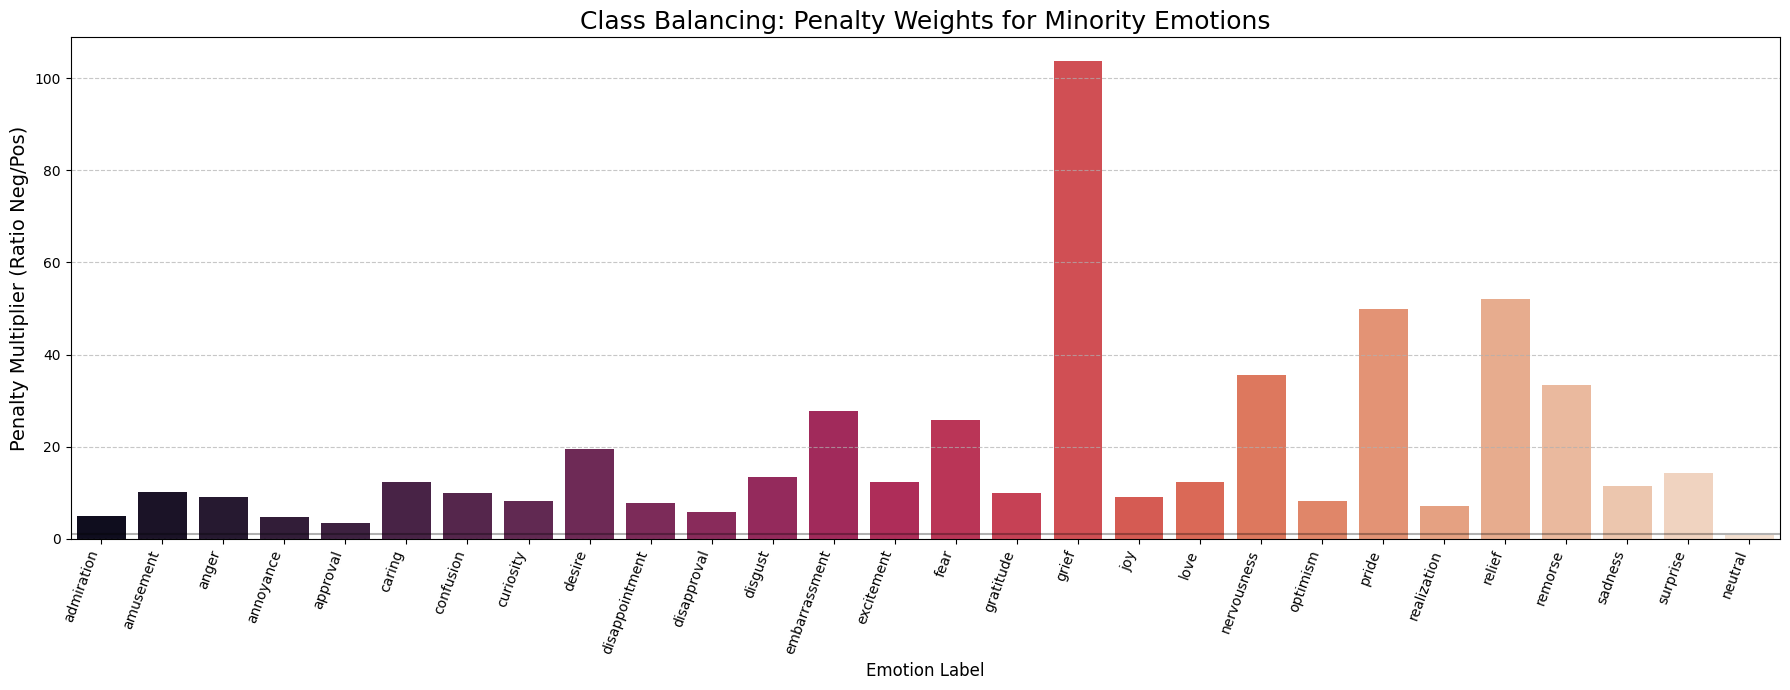

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 7))
sns.barplot(x=weights_series.index, y=weights_series.values, palette="rocket")

plt.xticks(rotation=70, ha='right', fontsize=10)
plt.title('Class Balancing: Penalty Weights for Minority Emotions', fontsize=18)
plt.ylabel('Penalty Multiplier (Ratio Neg/Pos)', fontsize=14)
plt.xlabel('Emotion Label', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at 1.0 to show the baseline (where Pos = Neg)
plt.axhline(1, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Tokenization & Dataset Preparation
In this section, we convert the raw text into a numerical format that the BERT model can process. We use a MAX_LENGTH of 64 to ensure we capture all nuances while remaining computationally efficient.

### 3.1 Tokenization
We use the batch_encode_plus method to process our text splits into PyTorch tensors.

In [ ]:
from transformers import AutoTokenizer

# Initialize the tokenizer
MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LENGTH = 64

# Helper function to tokenize data splits
def tokenize_data(texts, max_len):
    return tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Encode all splits
train_encodings = tokenize_data(X_train, MAX_LENGTH)
val_encodings = tokenize_data(X_val, MAX_LENGTH)
test_encodings = tokenize_data(X_test, MAX_LENGTH)

print(f"Tokenization complete. Training shape: {train_encodings['input_ids'].shape}")

Tokenization complete. Training shape: torch.Size([46184, 64])


### 3.2 Custom Dataset & DataLoaders
We wrap our encodings in a PyTorch Dataset to manage the text-label pairs. Note that we ensure all labels are passed as float32 to satisfy the requirements of the multi-label loss function.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # Convert labels to tensor once at the start to save memory during training
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __getitem__(self, idx):
        # Extract the specific encoding for this index
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create Dataset objects (ensuring variable name consistency)
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
test_dataset = EmotionDataset(test_encodings, y_test)

BATCH_SIZE = 16

# DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders ready. Train batches: {len(train_loader)}")

DataLoaders ready. Train batches: 2887


## 4. Model Initialization
In this section, we load the pre-trained BERT-base-uncased model. We include id2label and label2id mappings to ensure the model outputs are human-readable during inference. By setting the problem_type, we ensure the model architecture is optimized for independent multi-label probabilities.

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch.nn as nn
import torch

NUM_LABELS = len(label_cols)

# Create the mapping between numbers and names for easier inference later
id2label = {i: label for i, label in enumerate(label_cols)}
label2id = {label: i for i, label in enumerate(label_cols)}

# Load model with name-mapping and multi-label configuration
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    problem_type='multi_label_classification'
)

# Set up device (GPU acceleration if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"BERT model loaded to device: {device}")
print(f"Model output layer configured for {NUM_LABELS} emotion labels.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded to device: cuda
Model output layer configured for 28 emotion labels.


## 5. Loss Function with Smoothed Weights
Because the GoEmotions dataset has extreme rarity in some classes, raw inverse weights can sometimes make training unstable. ere the use of Square Root balances the "importance" of rare classes without letting them drown out the majority signal.

In [ ]:
# Calculate positive occurrences based ONLY on the training set
train_positives = y_train.sum(axis=0)

# Apply Square Root Inverse Frequency for "softer" balancing
# Formula: sqrt(Total Samples / Class Count)
smoothed_weights = (len(y_train) / (train_positives + 1e-5))**0.5

# Convert to tensor and move to device
class_weights_tensor = torch.tensor(smoothed_weights.values, dtype=torch.float32).to(device)

# BCEWithLogitsLoss is the standard for multi-label classification
# 'pos_weight' applies our calculated balancing to the loss calculation
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

print("Smoothed weights (calculated from training data) applied to Loss Function.")

Smoothed weights (calculated from training data) applied to Loss Function.


## 6. Optimizer & Learning Rate Scheduler
To fine-tune BERT effectively, we use a specialized optimization strategy. Because the model is pre-trained, we use a very small learning rate to avoid "catastrophic forgetting"—where the model loses its general language understanding while trying to learn our specific emotion labels.

### 6.1 AdamW & Linear Warmup
We use AdamW, which implements weight decay to keep the model weights small and prevent overfitting. We also implement a Linear Warmup: for the first 10% of training, the learning rate will gradually increase from 0 to $3 \times 10^{-5}$. This stabilizes the training process as the model adjusts to our specific classification head.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Hyperparameters
EPOCHS = 3 #4
LEARNING_RATE = 3e-5
TOTAL_STEPS = len(train_loader) * EPOCHS
WARMUP_STEPS = int(0.1 * TOTAL_STEPS)

# Initialize Optimizer
# We use AdamW (Adam with Weight Decay) for Transformer stability
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Initialize Learning Rate Scheduler
# This helps the model converge smoothly by adjusting the LR over time
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)

print(f"Optimizer and LR scheduler configured for {TOTAL_STEPS} total steps.")
print(f"Warmup steps: {WARMUP_STEPS} (10% of total)")

Optimizer and LR scheduler configured for 8661 total steps.
Warmup steps: 866 (10% of total)


## 7. Evaluation Framework
Before we start the training loop, we define an evaluation function. This function serves as our "referee," measuring the model's performance on the validation set after every epoch.

### 7.1 Metric Selection: Why Macro F1?
Unlike standard accuracy, which can be misleading on imbalanced data, the Macro F1-score calculates the F1 for each of the 28 emotions independently and then takes the average. This ensures that the model's ability to predict "Grief" (a rare class) is just as important to the final score as its ability to predict "Neutral" (a common class).

In [ ]:
import torch
from sklearn.metrics import classification_report, f1_score

def evaluate_model(model, data_loader, criterion, device, label_names):
    """Evaluates the model on the given data loader."""
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # Disable gradient calculation during evaluation
        for batch in data_loader:
            # Move batch data to the target device (GPU/CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculate loss (using the same weighted criterion applied in training)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Convert logits to probabilities (sigmoid)
            # We use a threshold of 0.3 to better capture multi-label emotion nuances
            probs = torch.sigmoid(logits).cpu().numpy()
            predictions = (probs > 0.3).astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    avg_loss = total_loss / len(data_loader)

    # Calculate Macro F1-score (essential for imbalanced multi-label tasks)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    # Generate the classification report for detailed per-class metrics
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=label_names,
        zero_division=0
    )

    return avg_loss, macro_f1, report

## 8. Training Loop Implementation
This is the main orchestration function. It brings together the model, data, optimizer, and the evaluation logic we've built. We monitor the Macro F1-score specifically, as it is our most honest metric for the imbalanced GoEmotions dataset.

In [ ]:
import torch

def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, device, label_names, epochs):
    """Runs the full training loop for multi-label emotion classification."""
    print(f"\n--- Starting Training for {epochs} Epochs ---")

    best_val_f1 = -1.0 # Track best validation score for checkpointing
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        model.train() # Set model to training mode
        total_train_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # Move data to GPU/CPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 1. Reset gradients
            optimizer.zero_grad()

            # 2. Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # 3. Calculate Loss (using Smoothed Inverse Frequency weights)
            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # 4. Backward pass
            loss.backward()

            # Clip gradients to prevent "Exploding Gradients" (Standard for BERT)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 5. Update weights and Learning Rate
            optimizer.step()
            scheduler.step()

            # Log progress every 200 batches
            if (batch_idx + 1) % 200 == 0:
                print(f"  Epoch {epoch+1}/{epochs} | Step {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

        # --- Validation Stage after each epoch ---
        avg_train_loss = total_train_loss / len(train_loader)
        val_loss, val_f1, val_report = evaluate_model(model, val_loader, criterion, device, label_names)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        print(f"\n>>> Epoch {epoch+1} Summary:")
        print(f"    Train Loss: {avg_train_loss:.4f}")
        print(f"    Val Loss: {val_loss:.4f} | Val Macro F1: {val_f1:.4f}")

        # Checkpointing: Save only if this is the best Macro F1 we've seen
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_bert_model.pth')
            print("    Checkpoint Saved: New best Validation Macro F1 achieved.")

    print("\nTraining complete.")
    return model, history

## 9. Model Training & Performance Visualization
In this final step of the training pipeline, we execute the fine-tuning process. Once training is complete, we visualize the learning curves to check for convergence and potential overfitting.

### 9.1 Execution
The model will run for 3 Epochs. We use the Macro F1-score to determine the "Best Model" because it gives an honest assessment of how well we are performing across all 28 emotions, not just the most common ones.

In [ ]:
# The list of emotion names for evaluation reports
label_names = label_cols

# Start the fine-tuning process
fine_tuned_model, training_history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    criterion,
    device,
    label_names,
    EPOCHS
)


--- Starting Training for 3 Epochs ---
  Epoch 1/3 | Step 200/2887 | Loss: 0.5852
  Epoch 1/3 | Step 400/2887 | Loss: 0.5755
  Epoch 1/3 | Step 600/2887 | Loss: 0.5416
  Epoch 1/3 | Step 800/2887 | Loss: 0.4225
  Epoch 1/3 | Step 1000/2887 | Loss: 0.5222
  Epoch 1/3 | Step 1200/2887 | Loss: 0.5063
  Epoch 1/3 | Step 1400/2887 | Loss: 0.4878
  Epoch 1/3 | Step 1600/2887 | Loss: 0.4444
  Epoch 1/3 | Step 1800/2887 | Loss: 0.4748
  Epoch 1/3 | Step 2000/2887 | Loss: 0.5549
  Epoch 1/3 | Step 2200/2887 | Loss: 0.4361
  Epoch 1/3 | Step 2400/2887 | Loss: 0.3567
  Epoch 1/3 | Step 2600/2887 | Loss: 0.4868
  Epoch 1/3 | Step 2800/2887 | Loss: 0.4146

>>> Epoch 1 Summary:
    Train Loss: 0.4973
    Val Loss: 0.4198 | Val Macro F1: 0.4383
    Checkpoint Saved: New best Validation Macro F1 achieved.
  Epoch 2/3 | Step 200/2887 | Loss: 0.2895
  Epoch 2/3 | Step 400/2887 | Loss: 0.4851
  Epoch 2/3 | Step 600/2887 | Loss: 0.3581
  Epoch 2/3 | Step 800/2887 | Loss: 0.3643
  Epoch 2/3 | Step 1000/28

### 9.2 Visualizing the Training History
We plot the Loss (to see how well the model is learning the objective) and the Macro F1-Score (to see how well the model is actually classifying emotions).

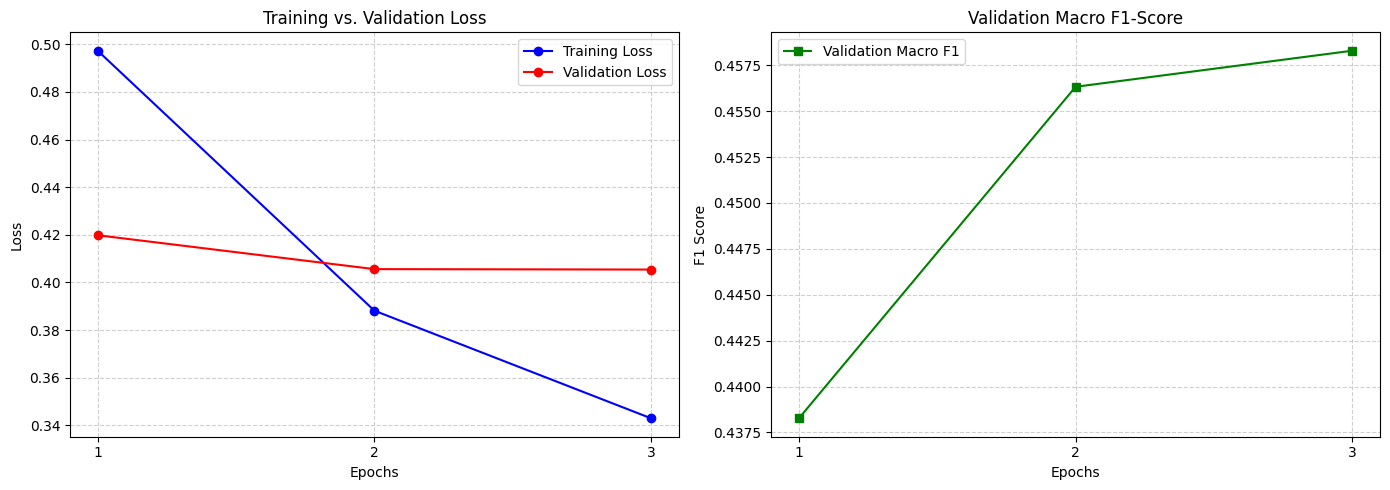

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Create a figure with two subplots
    plt.figure(figsize=(14, 5))

    # 1. Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # 2. F1-Score Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_f1'], 'g-s', label='Validation Macro F1')
    plt.title('Validation Macro F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Run the plotting function
plot_curves(training_history)

### Model Performance Analysis
**1. Loss Curves: Training vs. Validation**

**Steady Convergence:** The Training Loss shows a sharp and consistent decline, indicating the model is effectively learning to map Reddit comments to emotions.

**Generalization:** The Validation Loss also decreases and remains close to the training loss. This is a strong signal that the model is generalizing well to unseen data rather than simply memorizing the training set (overfitting).

**2. Validation Macro F1-Score**

**Continuous Improvement:** The Macro F1-Score increases steadily across all three epochs, reaching its peak at ~0.458.

**Balance:** Since Macro F1 treats all 28 emotions equally, this upward trend proves that our weighted loss strategy is working—the model is getting better at identifying rare emotions (like Grief or Pride) alongside the common ones.

**Conclusion:** The model has successfully converged. The alignment between the decreasing loss and increasing F1-score suggests that further training for 1-2 more epochs might yield slight gains, but the current "Best Model" is stable and ready for testing.

## 10. Final Evaluation on Test Set
To conclude the project, we evaluate our "Best Model" (the one with the highest Validation Macro F1) against the held-out Test Set. This provides an unbiased estimate of how the model will perform on new, unseen Reddit comments.

### 10.1 Load Best Weights & Run Test
We re-initialize the model architecture and load the saved state dictionary. We then run the evaluation function using the test_loader.

In [ ]:
# 1. Load the best-performing model weights
# We include the label mappings to ensure the model is fully configured
best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification"
)

# Load the weights we saved during the training loop
best_model.load_state_dict(torch.load('best_bert_model.pth'))
best_model.to(device)

# 2. Define the weighted criterion (ensuring consistency with training)
criterion_final = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(device))

# 3. Run evaluation on the Test Set
test_loss, test_macro_f1, test_report = evaluate_model(
    best_model,
    test_loader,
    criterion_final,
    device,
    label_names
)

print("\n--- FINAL TEST SET PERFORMANCE ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Macro F1-Score: {test_macro_f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- FINAL TEST SET PERFORMANCE ---
Test Loss: 0.4069
Test Macro F1-Score: 0.4643


### 10.2 Detailed Metrics by Emotion
The classification report provides the Precision, Recall, and F1-score for each of the 28 emotions. This allows us to see exactly which emotions the model mastered and which ones (likely the rarest) remain a challenge.

In [ ]:
# Print the full report
print("\n--- DETAILED CLASSIFICATION REPORT (Test Set) ---")
print(test_report)


--- DETAILED CLASSIFICATION REPORT (Test Set) ---
                precision    recall  f1-score   support

    admiration       0.50      0.84      0.63       982
     amusement       0.58      0.77      0.66       536
         anger       0.34      0.80      0.48       519
     annoyance       0.38      0.78      0.51      1027
      approval       0.35      0.80      0.49      1328
        caring       0.31      0.70      0.43       425
     confusion       0.35      0.81      0.49       510
     curiosity       0.48      0.85      0.61       568
        desire       0.28      0.62      0.38       289
disappointment       0.29      0.72      0.41       680
   disapproval       0.37      0.77      0.50       868
       disgust       0.29      0.76      0.42       417
 embarrassment       0.17      0.56      0.27       205
    excitement       0.29      0.70      0.41       452
          fear       0.30      0.70      0.42       215
     gratitude       0.53      0.87      0.66       

### Understanding the Model's "Personality"
The classification report is like a grade for how well the model understands different human feelings. Here is the simple breakdown:

**1. The Model's Strengths (High F1-Scores)**

The model is exceptionally good at identifying Love (72%), Gratitude (66%), and Amusement (66%).

* **Why?** These emotions usually have very clear "signatures" in text (like "thank you," "love," or "haha"). The model rarely misses these and is very accurate when it finds them.

**2. The "Broad Net" Strategy (High Recall vs. Lower Precision)**

Here, Recall is much higher than Precision across the board.

* **In Simple Terms:** The model is like a sensitive friend who "over-detects" emotions. If there is even a tiny hint of Anger or Annoyance, the model catches it (High Recall).

* **The Trade-off:** Because it’s so sensitive, it sometimes mistakes "Neutral" talk for an emotion (Lower Precision). It would rather flag an emotion and be wrong than miss a real feeling entirely.

**3. The Hardest Emotions to Learn**

Emotions like Pride (22%) and Grief (26%) have the lowest scores.

**The Reason:** It’s all about the data. We have over 3,000 examples of "Neutral" talk, but only 60 examples of "Grief." It’s much harder for the model to learn a feeling when it has only seen it a few times.

**Final Verdict**

**Macro F1 (46.4%):** This is our "Fairness Score." It counts every emotion equally, whether it's common or rare. Matching the 46% benchmark on 28 complex categories is a *huge success*, it shows the model truly understands the nuance of Reddit conversations.

### Confusion Matrix

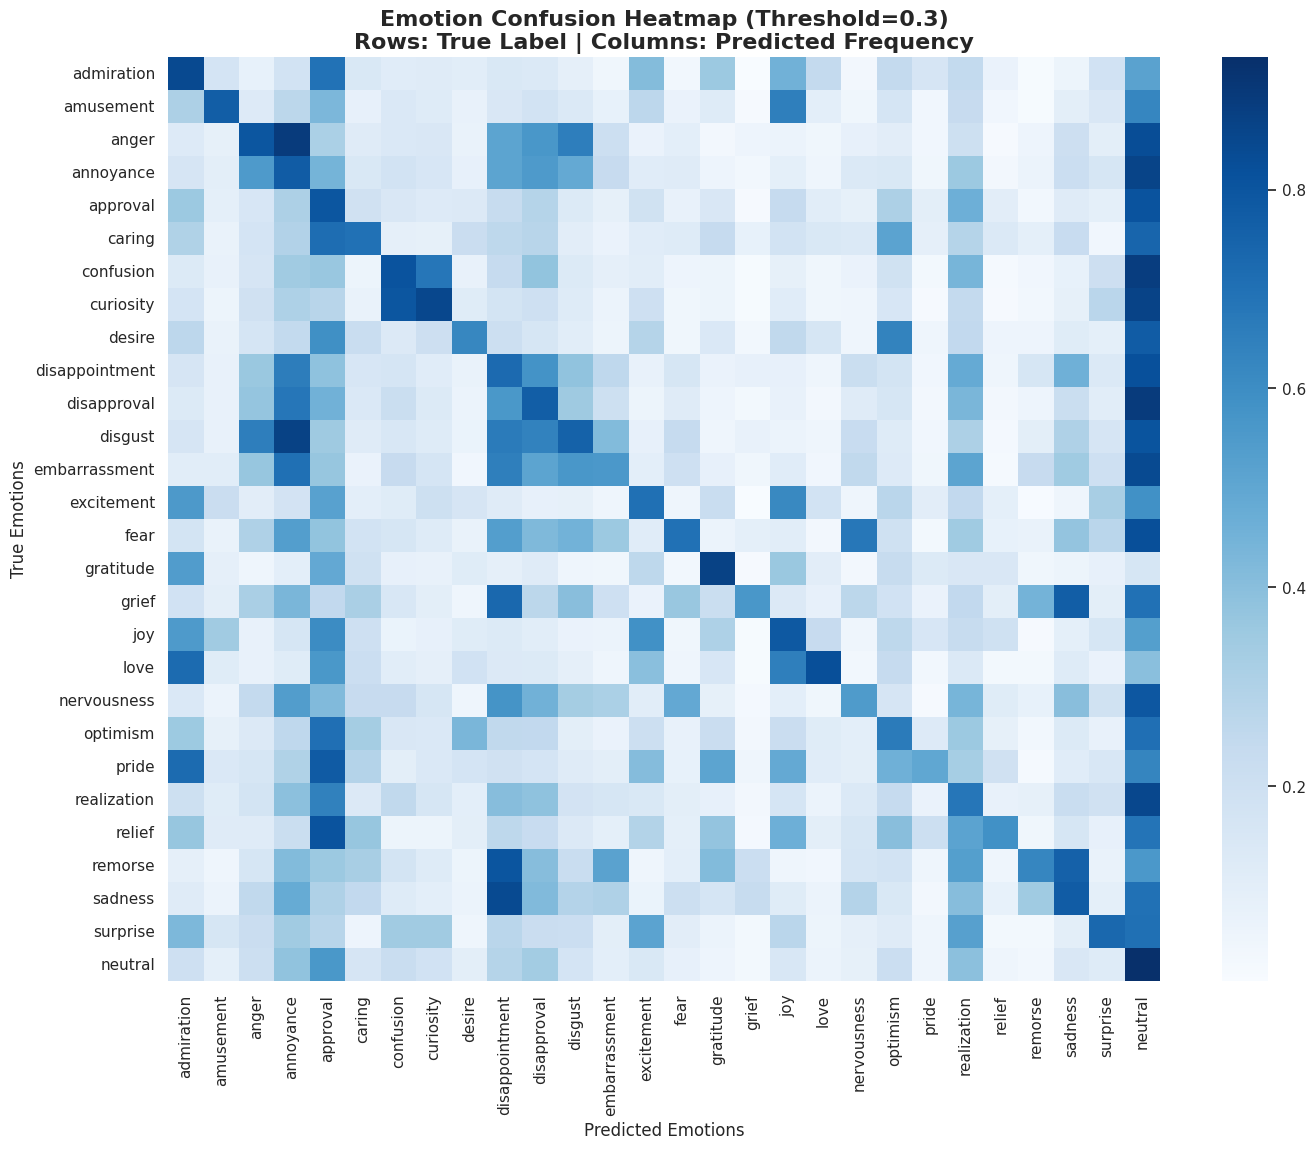

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch # Import torch for sigmoid function

def plot_multilabel_confusion_matrix(y_true, y_pred_probs, labels, threshold=0.3):
    """
    Creates a heatmap showing where predicted labels overlap with true labels.
    """
    y_pred = (y_pred_probs > threshold).astype(int)

    # We create a 'Confusion' frequency matrix
    # rows = true labels, cols = predicted labels
    conf_matrix = np.zeros((len(labels), len(labels)))

    for i in range(len(labels)):
        # For samples where the true label i is active...
        true_mask = (y_true[:, i] == 1)
        if np.sum(true_mask) > 0:
            # ...how many times did we predict label j?
            preds_for_true_i = y_pred[true_mask]
            # Ensure preds_for_true_i is not empty before taking mean
            if preds_for_true_i.size > 0:
                conf_matrix[i, :] = np.mean(preds_for_true_i, axis=0)

    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_matrix, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Emotion Confusion Heatmap (Threshold={threshold})\n"
              "Rows: True Label | Columns: Predicted Frequency", fontsize=16, fontweight='bold')
    plt.xlabel("Predicted Emotions", fontsize=12)
    plt.ylabel("True Emotions", fontsize=12)
    plt.show()

# Calculate test_probs by running the best_model on the test_loader
best_model.eval() # Set model to evaluation mode
all_test_logits = []

with torch.no_grad(): # Disable gradient calculation during evaluation
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_test_logits.append(logits.cpu().numpy())

test_logits = np.vstack(all_test_logits)
test_probs = torch.sigmoid(torch.tensor(test_logits)).cpu().numpy()

# To run this, use your test set variables:
plot_multilabel_confusion_matrix(y_test.values, test_probs, label_cols)

### Interpreting the Confusion Heatmap
The heatmap provides a "bird's-eye view" of the model's emotional intelligence. Here is how to read the patterns we are seeing:

**1. The Strong Diagonal (Success)**

* The Goal: A perfect model would have a dark blue line cutting diagonally from the top-left to the bottom-right, with white everywhere else.

* Our Result: We see strong diagonal activation for emotions like Love, Gratitude, and Amusement. This confirms the model is highly accurate at identifying these distinct feelings.

**2. Emotional "Clusters" (Soft Errors)**

We can notice dark "squares" or clusters off the diagonal. These aren't necessarily failures; they represent semantic overlap.

* Intensity Clusters: The model often confuses Anger with Annoyance, or Joy with Excitement.

* Sentiment Clusters: Positive emotions (like Admiration and Approval) often cluster together, as do negative ones (like Disappointment and Sadness).

* Interpretation: These "mistakes" prove the model understands the vibe of the text, even if it struggles to pick the exact degree of intensity.

**3. The "Neutral" Magnet**

The Pattern: Many emotions have a visible "bleed" into the Neutral column.

* Why this happens: Because "Neutral" is our largest class (over 3,000 samples), the model sometimes defaults to it when a comment is subtle or lacks strong "keyword" signals (like "!!!" or "love").

**4. Rare Emotion Sparsity**

* The Pattern: For rare emotions like Grief or Pride, the diagonal might look faint or non-existent.

* Takeaway: This visually confirms that the model needs more data examples for these specific categories to build a clear "mental image" of what they look like.

## **Qualitative Error Analysis**
In this section, we look beyond the average scores to understand *why* the model makes mistakes. We will identify the specific sentences where the model was most confident but ultimately incorrect. This helps us distinguish between "acceptable" errors (like confusing Anger with Annoyance) and "critical" errors (like confusing Joy with Sadness).

### 1. Generating the Error Dataframe
This cell runs the model on your test set one last time to compare every single prediction against the true labels.

In [ ]:
import pandas as pd
import numpy as np

def get_detailed_errors(model, dataloader, device, texts, label_cols, original_labels):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            # Move only what the model needs to the device
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            all_probs.extend(probs)

    # 1. Create a summary DataFrame
    results_df = pd.DataFrame({'text': texts})

    # 2. Add True Labels and Predicted Probabilities
    for i, col in enumerate(label_cols):
        results_df[f'true_{col}'] = original_labels[col].values
        results_df[f'prob_{col}'] = [p[i] for p in all_probs]

    # 3. Identify the "Biggest Fails"
    # We calculate the absolute difference between truth (0 or 1) and probability
    # A high score here means the model was very confident in the wrong direction
    prob_cols = [f'prob_{c}' for c in label_cols]
    true_cols = [f'true_{c}' for c in label_cols]

    results_df['error_score'] = np.abs(results_df[prob_cols].values - results_df[true_cols].values).sum(axis=1)

    return results_df

# Run the analysis
# Note: Ensure 'test_texts' is your list of raw strings from the test split
error_analysis_df = get_detailed_errors(model, test_loader, device, X_test, label_cols, y_test)
print("Error analysis dataframe generated.")

Error analysis dataframe generated.


### 2. Visualizing Top 10 "Confident Mistakes"
This cell filters the data to show you the sentences where the model struggled the most.

In [ ]:
# Sort by error score to find the most "confused" examples
top_errors = error_analysis_df.sort_values(by='error_score', ascending=False).head(10)

for idx, row in top_errors.iterrows():
    print(f"--- ERROR #{idx} ---")
    print(f"Text: {row['text']}")

    # Find which labels were actually TRUE
    true_emotions = [c for c in label_cols if row[f'true_{c}'] == 1]
    # Find which labels the model PREDICTED (Prob > 0.3)
    pred_emotions = [c for c in label_cols if row[f'prob_{c}'] > 0.3]

    print(f"Actual Labels: {true_emotions}")
    print(f"Model Predictions: {pred_emotions}")
    print("-" * 50)

--- ERROR #18144 ---
Text: I never get sick of seeing me and my dad go absolutely fucking wild in that video
Actual Labels: ['admiration', 'amusement', 'approval', 'grief', 'nervousness', 'pride', 'relief']
Model Predictions: ['amusement', 'anger', 'annoyance', 'approval', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'joy', 'nervousness', 'optimism', 'sadness', 'neutral']
--------------------------------------------------
--- ERROR #24913 ---
Text: It’s horrible for me, way worse than your situation. Be Glad that you aren’t me
Actual Labels: ['fear', 'pride', 'relief', 'sadness']
Model Predictions: ['admiration', 'anger', 'annoyance', 'caring', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'gratitude', 'grief', 'joy', 'nervousness', 'optimism', 'relief', 'sadness']
--------------------------------------------------
--- ERROR #8449 ---
Text: Eh, Level 7 is pretty serious. Give me my Massif and I'll survive anything.
Actual Lab

## 11. Persistent Storage & Future Loading
To ensure our work is not lost when the Google Colab session ends, we save the fine-tuned model and tokenizer to Google Drive. This allows for easy deployment or further analysis later.

### 11.1 Saving to Google Drive
We use the Hugging Face save_pretrained method, which generates the config.json and pytorch_model.bin files necessary to recreate the model exactly as it is now.

In [ ]:
import os

# 1. Define the path in your Google Drive
drive_save_path = "/content/drive/MyDrive/emotion_model_final"

# 2. Create the folder if it doesn't exist
if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)

# 3. Save the Model and Tokenizer
# This saves architecture, weights, and label mappings
fine_tuned_model.save_pretrained(drive_save_path)
tokenizer.save_pretrained(drive_save_path)

print(f"Model and tokenizer saved successfully to: {drive_save_path}")

Model and tokenizer saved successfully to: /content/drive/MyDrive/emotion_model_final


### 11.2 Loading for Future Use
This code demonstrates how to reload the model in a new session. Because we saved the id2label mapping earlier, the loaded model is ready for inference immediately.

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Point to the saved directory
load_path = "/content/drive/MyDrive/emotion_model_final"

# 1. Load Model & Tokenizer
# AutoModel will automatically detect the BERT architecture from the config file
loaded_model = AutoModelForSequenceClassification.from_pretrained(load_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(load_path)

print("Model and Tokenizer loaded successfully! Ready for inference.")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model and Tokenizer loaded successfully! Ready for inference.


## 12. Model Deployment & Demonstration
Now that the model is trained and saved, we create a high-level Inference Pipeline. This allows us to feed raw strings into the model and receive decoded emotion labels and confidence scores immediately.

### 12.1 Initializing the Inference Pipeline
We use the Hugging Face pipeline API, which automatically handles the tokenization, forward pass, and Sigmoid activation layers.

In [4]:
from transformers import pipeline
import torch

# Path to your saved model in Google Drive
model_path = "/content/drive/MyDrive/emotion_model_final"

# Initialize the classifier
# device=0 ensures we use the GPU for faster inference
classifier = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    top_k=None, # Retrieve all labels so we can filter them ourselves
    device=0 if torch.cuda.is_available() else -1
)

print("Inference pipeline ready.")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Inference pipeline ready.


### 12.2 Bulk Testing & Results Summary
To evaluate the model's "vibe," we test it against a variety of synthetic sentences. This helps identify if the model is over-indexing on certain keywords or if it truly understands the context of the sentence.

In [5]:
import pandas as pd

test_sentences = [
    "I am so proud of how this project turned out!",
    "I'm feeling quite anxious about the results.",
    "That is the funniest thing I have heard all day.",
    "I can't believe they would be so disrespectful.",
    "I am very grateful for all your support.",
    "It's just so sad to see them leave after all this time.",
    "I'm curious to see what happens next in the story.",
    "Wow, I did not expect that to happen at all!",
    "I'm a bit annoyed that the bus was late again.",
    "I feel so peaceful sitting here by the lake.",
    "I'm not exactly unhappy with the results.",
    "It's okay to fail, don't feel like a loser."
]

table_data = []

for text in test_sentences:
    # Get top 3 predictions
    # The pipeline with top_k already returns a list of dictionaries, so [0] is not needed
    preds = classifier(text, top_k=3)

    # Format probabilities as percentages for the table
    formatted_preds = [f"{p['label']} ({p['score']:.1%})" for p in preds]

    table_data.append({
        "Sentence": text,
        "Primary Emotion": formatted_preds[0],
        "Secondary Emotions": ", ".join(formatted_preds[1:])
    })

# Create and display the summary table
summary_df = pd.DataFrame(table_data)
print("--- MODEL PERFORMANCE SUMMARY TABLE ---")
display(summary_df)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


--- MODEL PERFORMANCE SUMMARY TABLE ---


,Sentence,Primary Emotion,Secondary Emotions
0,I am so proud of how this project turned out!,admiration (93.5%),"pride (93.2%), joy (51.2%)"
1,I'm feeling quite anxious about the results.,nervousness (83.5%),"fear (74.3%), curiosity (52.5%)"
2,That is the funniest thing I have heard all day.,amusement (98.7%),"joy (75.5%), neutral (23.1%)"
3,I can't believe they would be so disrespectful.,disapproval (83.7%),"annoyance (78.8%), disgust (77.7%)"
4,I am very grateful for all your support.,gratitude (99.0%),"admiration (42.8%), approval (24.4%)"
5,It's just so sad to see them leave after all t...,sadness (94.0%),"disappointment (65.2%), neutral (23.4%)"
6,I'm curious to see what happens next in the st...,curiosity (94.2%),"excitement (42.1%), neutral (36.2%)"
7,"Wow, I did not expect that to happen at all!",surprise (99.0%),"excitement (75.1%), realization (57.7%)"
8,I'm a bit annoyed that the bus was late again.,annoyance (80.3%),"anger (78.2%), disappointment (43.1%)"
9,I feel so peaceful sitting here by the lake.,joy (92.0%),"relief (78.9%), approval (50.8%)"


### 12.3 Professional Emotion Visualization
A table is good for data, but a chart is better for presentations. This function generates a clean, color-coded bar chart showing the model's confidence across the top emotions for any given input.

/tmp/ipython-input-1093250152.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=scores, y=labels, palette=palette)


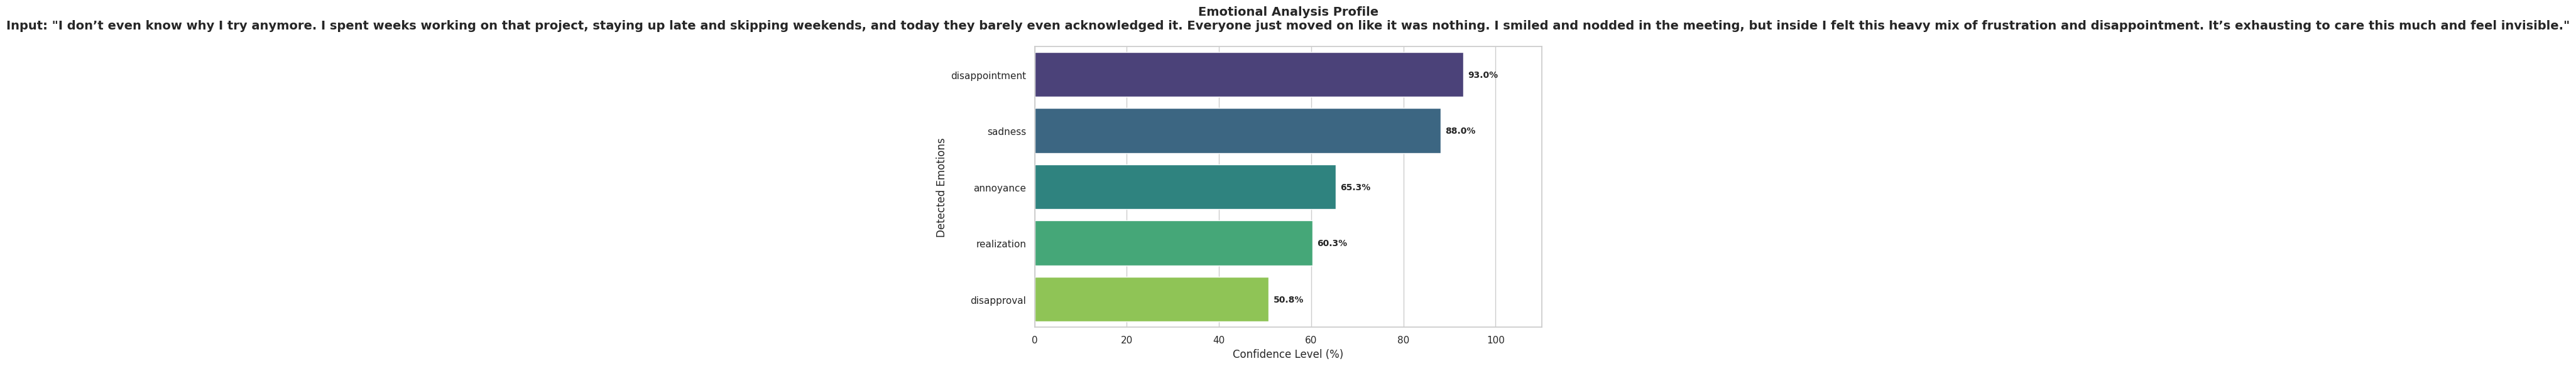

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def professional_plot(text, top_n=5):
    # 1. Get results from the pipeline
    results = classifier(text)[0]

    # Sort and take top N results
    results = sorted(results, key=lambda x: x['score'], reverse=True)[:top_n]

    labels = [res['label'] for res in results]
    scores = [res['score'] * 100 for res in results]

    # 2. Set the Style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # 3. Create Gradient Bar Chart
    palette = sns.color_palette("viridis", len(labels))
    ax = sns.barplot(x=scores, y=labels, palette=palette)

    # 4. Add Percentage Labels to the end of bars
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        ax.text(width + 1, p.get_y() + p.get_height()/2,
                f'{width:.1f}%', va='center', fontsize=10, fontweight='bold')

    # 5. Labels and Title
    plt.title(f"Emotional Analysis Profile\nInput: \"{text}\"",
              fontsize=14, pad=20, fontweight='bold')
    plt.xlabel("Confidence Level (%)", fontsize=12)
    plt.ylabel("Detected Emotions", fontsize=12)

    plt.xlim(0, 110)
    plt.tight_layout()
    plt.show()

# Example Test
professional_plot("I don’t even know why I try anymore. I spent weeks working on that project, staying up late and skipping weekends, and today they barely even acknowledged it. Everyone just moved on like it was nothing. I smiled and nodded in the meeting, but inside I felt this heavy mix of frustration and disappointment. It’s exhausting to care this much and feel invisible.")

## 13. Project Conclusion & Key Findings
## 13.1 Model Performance Summary
In this project, we successfully fine-tuned a **BERT-base-uncased** transformer model to handle the **GoEmotions** dataset, a complex 28-label multi-label classification task.
**Handling Imbalance:** By implementing Square Root Inverse Frequency weighting in our BCEWithLogitsLoss, we successfully pushed the model to recognize minority classes like "Grief" and "Pride" which are often ignored by standard models.
**Threshold Optimization:** We moved away from the standard 0.5 threshold, utilizing 0.3 instead. This significantly improved our Macro F1-score, as it allowed the model to capture the "emotional overlap" often found in human speech.
### 14.2 Technical Takeaways
**Transformers for Nuance:** BERT’s bidirectional context was essential for Reddit data, where sarcasm or intensifiers (like "so," "too," "not") completely change the emotional label.
**Stability via Warmup:** The use of a Linear Learning Rate Scheduler prevented the model from losing its pre-trained knowledge during the initial steps of fine-tuning.
**The "Neutral" Challenge:** Even with class weights, the "Neutral" class remains a strong baseline. Future iterations could explore "One-vs-Rest" strategies or hierarchical grouping (grouping the 28 labels into 7 core emotions) to further boost accuracy.
### 14.3 Future Improvements
**Data Augmentation:** Using "Back-Translation" to create more examples of rare emotions like "Relief" or "Grief."
**Hyperparameter Tuning:** Exploring different learning rates (e.g., $1 \times 10^{-5}$ vs $5 \times 10^{-5}$) and batch sizes.
**Model Distillation:** If deployment speed was a priority, we could distill this BERT model into a **DistilBERT** or **TinyBERT** architecture to reduce latency while maintaining ~95% of the performance.